# SimCLR Contrastive Pretraining - Vision Transformer (50 Epochs)

## Transformer Architecture Self-Supervised Learning

**Objective**: Pretrain Vision Transformer (ViT-B/16) encoder using SimCLR contrastive learning on BigEarthNet-S2. This pretraining is **essential** for ViT to achieve competitive performance.

**Architecture**: 
- **Encoder**: Vision Transformer Base (ViT-B/16)
- **Projection Head**: 2-layer MLP (768 → 768 → 128)
- **Parameters**: 85.8M (encoder only, largest model)
- **Patch Size**: 16×16 patches

**Pretraining Dataset**:
- **BigEarthNet-S2**: 269,695 Sentinel-2 satellite image patches
- **Image Size**: 224×224 pixels (ViT standard)
- **Coverage**: 100% of BigEarthNet dataset
- **Labels**: Not used (self-supervised learning)

**SimCLR Configuration**:
- **Training**: 50 epochs (critical for ViT convergence)
- **Batch Size**: 64
- **Learning Rate**: 1e-3
- **Temperature**: 0.5 (NT-Xent loss)
- **Loss**: Normalized Temperature-scaled Cross Entropy (NT-Xent)

**Augmentation Strategy** (Satellite-Specific):
1. Random resized crop (scale 0.2-1.0)
2. Random horizontal/vertical flips
3. Color jitter (brightness, contrast, saturation)
4. Random grayscale (20%)
5. Gaussian blur
6. Solarization (ViT-specific)

**Output**:
- Pretrained ViT encoder saved as: `best_contrastive_model_vit_*.pth`
- Ready for supervised fine-tuning on EuroSAT

**Training Time**: ~80-100 hours on RTX 3090 (longest pretraining)

**Critical Note**: Without this pretraining, ViT achieves only 50.31% accuracy from scratch. After pretraining, performance improves to ~90.98%, demonstrating the **absolute necessity** of pretraining for transformer architectures.

**Next Step**: After pretraining, proceed to `07_finetune_vit_after_simclr.ipynb` for supervised fine-tuning.

## 1. Import Libraries

### Core Deep Learning Frameworks
- **PyTorch**: Neural network construction, training, and inference
- **torchvision**: Pretrained Vision Transformer (ViT-B/16), data augmentations, and EuroSAT dataset
- **torch.cuda.amp**: Automatic Mixed Precision (AMP) for faster training with FP16

### Data Processing
- **PIL (Pillow)**: Image loading and custom augmentation implementations
- **numpy**: Numerical operations and array manipulations
- **datasets (HuggingFace)**: BigEarthNet-S2 loading for contrastive pretraining

### Evaluation Metrics
- **sklearn.metrics**: ROC curves, AUROC, Precision-Recall curves, AUPR
- **FPR@95TPR**: False Positive Rate when True Positive Rate = 95%

### Visualization
- **matplotlib**: Training curves, loss plots, UMAP embeddings
- **seaborn**: Enhanced statistical visualizations
- **tqdm**: Progress bars for training loops

### Reproducibility
- **Random seed setting**: Ensures deterministic results across runs (seed=42)
- **cudnn.benchmark**: Enables cuDNN autotuner for optimal convolution algorithms (non-deterministic but faster)
- **cudnn.deterministic**: Disabled for performance (set to True for 100% reproducibility)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT
from PIL import Image  # Added for custom augmentations

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from tqdm.auto import tqdm
import os
import random
import copy
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # NOTE: For maximum GPU performance, we enable cudnn.benchmark
    # This finds the fastest convolution algorithms for your hardware
    # Set to False only if you need 100% reproducibility
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic ops for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for best performance

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==========================================
# CONFIGURATION - VISION TRANSFORMER (ViT) VERSION
# ==========================================

# ✔ ViT-B/16 REQUIRES 224x224 INPUT
IMG_SIZE = 224  # Standard input size for Vision Transformers

# Batch Size - REDUCED for ViT (transformer model + larger images)
BATCH_SIZE = 32  # Reduced due to ViT memory requirements (224x224 input + attention)
NUM_WORKERS = 6  # Enable parallel data loading on Linux (0 for Windows)

# Contrastive Learning Parameters
CONTRASTIVE_EPOCHS = 50  # Pretraining epochs
CONTRASTIVE_LR = 1e-3
CONTRASTIVE_TEMP = 0.5  # Temperature for NT-Xent loss
PROJECTION_DIM = 128  # Projection head dimension

# Supervised Fine-tuning Parameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
MC_SAMPLES = 50  # Number of MC dropout samples

print("="*80)
print("✅ CONFIGURATION - VISION TRANSFORMER (ViT) VERSION")
print("="*80)
print(f"🔧 Vision Transformer Adaptations:")
print(f"  • Image Size: 64 → {IMG_SIZE} (ViT-B/16 requirement)")
print(f"  • Batch Size: 64 → {BATCH_SIZE} (larger images + attention)")
print(f"  • Feature Dim: 256 → 768 (ViT-B/16 output)")
print(f"  • Backbone: Custom CNN → Vision Transformer (ViT-B/16)")
print(f"  • Architecture: 12 layers, 12 heads, 16x16 patches")
print(f"\n📊 Training Setup:")
print(f"  • Contrastive: {CONTRASTIVE_EPOCHS} epochs")
print(f"  • Supervised: {NUM_EPOCHS} epochs")
print(f"  • Dropout: {DROPOUT_RATE}")
print("="*80)

✅ CONFIGURATION - VISION TRANSFORMER (ViT) VERSION
🔧 Vision Transformer Adaptations:
  • Image Size: 64 → 224 (ViT-B/16 requirement)
  • Batch Size: 64 → 32 (larger images + attention)
  • Feature Dim: 256 → 768 (ViT-B/16 output)
  • Backbone: Custom CNN → Vision Transformer (ViT-B/16)
  • Architecture: 12 layers, 12 heads, 16x16 patches

📊 Training Setup:
  • Contrastive: 50 epochs
  • Supervised: 100 epochs
  • Dropout: 0.1


## 2. Contrastive Self-Supervised Pretraining (Stage 1)

### Motivation: Why Contrastive Learning?

Supervised learning requires large labeled datasets, which are expensive to obtain for satellite imagery. **Contrastive self-supervised learning** enables models to learn robust feature representations from **unlabeled data** by solving a pretext task: distinguishing between different augmented views of the same image.

### SimCLR Framework Overview

**SimCLR** (Simple Framework for Contrastive Learning of Visual Representations) learns representations by maximizing agreement between differently augmented views of the same image while minimizing agreement with other images.

**Key Components:**
1. **Data Augmentation Module**: Generates two correlated views (x_i, x_j) from each image x
2. **Encoder Network** f(·): Extracts feature representations (Vision Transformer ViT-B/16)
3. **Projection Head** g(·): Maps features to contrastive loss space (768 → 128 dimensions)
4. **Contrastive Loss**: NT-Xent loss encourages similar representations for augmented pairs

**Mathematical Formulation:**

Given a batch of N images, we create 2N augmented views. For a positive pair (i, j):

$$
\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k) / \tau)}
$$

where:
- z_i = g(f(x_i)) is the projection of the encoded representation
- sim(·, ·) is cosine similarity
- τ is the temperature parameter (controls concentration of distributions)
- The denominator includes all negative pairs (2N-1 samples excluding i)

**Why This Works for Satellite Imagery:**

1. **Invariance Learning**: Model learns features invariant to transformations (rotation, color, occlusion)
2. **Semantic Understanding**: Contrastive learning captures high-level scene semantics without labels
3. **Transfer Learning**: Pretrained features generalize well to downstream classification tasks
4. **Domain Adaptation**: BigEarthNet pretraining provides robust features for EuroSAT fine-tuning

### Implementation Details

- **Pretraining Dataset**: BigEarthNet-S2 (269,695 unlabeled multispectral images)
- **Backbone**: Vision Transformer (ViT-B/16) initialized with ImageNet weights
- **Training**: 50 epochs, batch size 32, learning rate 1e-3, temperature τ=0.5
- **Optimization**: Adam optimizer with Cosine Annealing scheduler
- **Mixed Precision**: FP16 automatic mixed precision (AMP) for faster training and lower memory
- **Output**: Pretrained encoder with learned 768-dimensional feature representations

### 2.1. Model Architecture with Contrastive Learning Support

### Architecture Overview: Vision Transformer (ViT-B/16)

**Why Vision Transformer over CNN?**

Traditional CNNs have inductive biases (locality, translation equivariance) that limit their ability to capture long-range spatial dependencies. **Vision Transformers** use self-attention mechanisms to model global relationships between image patches, making them ideal for satellite imagery where context matters (e.g., a building's surroundings help classify it).

### ViT-B/16 Architecture Details

**Input Processing:**
- Input image: 224×224×3 RGB
- Patch extraction: Divide image into 14×14 grid of 16×16 patches (196 patches total)
- Linear projection: Each patch → 768-dimensional embedding
- Position embeddings: Added to preserve spatial information (learned, not fixed)
- [CLS] token: Prepended special token whose final representation is used for classification

**Transformer Encoder:**
- **Layers**: 12 Transformer blocks
- **Attention Heads**: 12 multi-head self-attention (MSA) heads per layer
- **Hidden Dimension**: 768
- **MLP Dimension**: 3072 (4× expansion in feedforward network)
- **Total Parameters**: ~86M (85.8M in encoder + 0.7M in projection head)

**Mathematical Formulation:**

For input image x ∈ ℝ^(224×224×3):

1. **Patch Embedding**:
   - x_p = [x_1^p, x_2^p, ..., x_196^p] where x_i^p ∈ ℝ^(16×16×3)
   - z_0 = [x_class; E·x_p^1; E·x_p^2; ...; E·x_p^196] + E_pos
   - E ∈ ℝ^(768×768) is the patch embedding matrix
   - E_pos ∈ ℝ^(197×768) are learnable position embeddings

2. **Transformer Block** (repeated 12 times):
   - z'_ℓ = MSA(LN(z_{ℓ-1})) + z_{ℓ-1}  (Multi-Head Self-Attention)
   - z_ℓ = MLP(LN(z'_ℓ)) + z'_ℓ  (Feedforward network)
   - LN: Layer Normalization

3. **Final Representation**:
   - h = LN(z_L^0)  (Extract [CLS] token representation from layer L=12)
   - Output: h ∈ ℝ^768

### Model Components

**1. ViTEncoder (Feature Extractor)**
- Loads pretrained ViT-B/16 from torchvision (ImageNet weights)
- Removes final classification head (replaces with Identity)
- Adds dropout (p=0.1) for regularization
- Output: 768-dimensional feature vectors

**2. ProjectionHead (Contrastive Learning)**
- **Purpose**: Maps 768-dim features to lower-dimensional space (128-dim) for contrastive loss
- **Architecture**: 
  - Linear(768 → 768) + ReLU
  - Linear(768 → 128)
- **Why needed?**: SimCLR paper shows projection improves contrastive learning quality
- **Not used during fine-tuning**: Discarded after pretraining

**3. ClassificationHead (Supervised Learning)**
- **Purpose**: Maps features to class logits with uncertainty quantification
- **Architecture**:
  - Linear(768 → 512) + ReLU + Dropout(0.1)
  - Linear(512 → 256) + ReLU + Dropout(0.1)
  - Linear(256 → num_classes)
- **MC Dropout**: Dropout layers remain active during inference for uncertainty estimation

**4. ContrastiveModel (Pretraining)**
- Combines ViTEncoder + ProjectionHead
- Used in Stage 1 for self-supervised learning on BigEarthNet
- Forward pass: image → features (768-dim) → projections (128-dim)

**5. SupervisedModel (Fine-tuning)**
- Combines ViTEncoder + ClassificationHead
- Used in Stage 2 for supervised learning on EuroSAT
- Forward pass: image → features (768-dim) → class logits (num_classes-dim)
- **Transfer Learning**: Encoder initialized with pretrained weights from Stage 1

### Design Rationale

**Why 768-dim features?**
- ViT-B/16 standard architecture (comparable to ResNet-50)
- Balances expressiveness vs. computational cost

**Why projection head?**
- SimCLR ablation studies show 2-layer MLP improves contrastive learning
- Lower-dimensional space (128) prevents dimensional collapse

**Why MC Dropout?**
- Provides Bayesian approximation to model uncertainty
- Epistemic uncertainty crucial for OOD detection
- T=50 stochastic forward passes balance accuracy vs. inference time

In [3]:
# ==========================================
# MODEL ARCHITECTURES - VISION TRANSFORMER ENCODER
# ==========================================
import torchvision.models as models

class ViTEncoder(nn.Module):
    """
    Vision Transformer (ViT-B/16) Encoder for contrastive pretraining.
    Can be initialized with or without ImageNet pretrained weights.
    Extracts 768-dimensional feature representations.
    """
    def __init__(self, pretrained=True, dropout_rate=0.3):
        super(ViTEncoder, self).__init__()
        
        # Load ViT-B/16 with or without pretrained weights
        vit = models.vit_b_16(pretrained=pretrained)
        
        # Remove the final classification head
        # ViT outputs 768-dim features from the class token
        self.vit = vit
        self.vit.heads = nn.Identity()
        
        # Feature dimension is 768 for ViT-B/16
        self.feature_dim = 768
        
        # Optional dropout
        self.dropout = nn.Dropout(p=dropout_rate)
        
        print(f"✓ Vision Transformer (ViT-B/16) initialized (pretrained={pretrained})")
        print(f"  Feature dimension: {self.feature_dim}")
        print(f"  Patch size: 16x16, Layers: 12, Heads: 12")
    
    def forward(self, x):
        x = self.vit(x)  # [B, 768]
        x = self.dropout(x)
        return x


class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR style).
    Maps 768-dim ViT features to projection_dim space.
    """
    def __init__(self, input_dim=768, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, projection_dim)
        )

    def forward(self, x):
        return self.projection(x)


class ClassificationHead(nn.Module):
    """
    Classification head with MC Dropout for uncertainty estimation.
    """
    def __init__(self, input_dim=768, num_classes=8, dropout_rate=0.3):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class ContrastiveModel(nn.Module):
    """
    Full model combining Vision Transformer encoder and projection head for contrastive learning.
    """
    def __init__(self, pretrained=True, dropout_rate=0.3, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = ViTEncoder(pretrained=pretrained, dropout_rate=dropout_rate)
        self.projection_head = ProjectionHead(self.encoder.feature_dim, projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections


class SupervisedModel(nn.Module):
    """
    Supervised model with pretrained Vision Transformer encoder and classification head.
    """
    def __init__(self, encoder, num_classes=8, dropout_rate=0.3):
        super(SupervisedModel, self).__init__()
        self.encoder = encoder
        # Get feature dimension from encoder
        feature_dim = encoder.feature_dim if hasattr(encoder, 'feature_dim') else 768
        self.classifier = ClassificationHead(feature_dim, num_classes, dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


print("="*80)
print("✅ MODEL ARCHITECTURES - VISION TRANSFORMER ENCODER")
print("="*80)
print("  ✓ ViTEncoder: Feature extraction (768-dim, ViT-B/16)")
print("  ✓ ProjectionHead: Contrastive learning projection (768→128)")
print("  ✓ ClassificationHead: Supervised classification with MC Dropout")
print("  ✓ ContrastiveModel: ViT + Projection (for pretraining)")
print("  ✓ SupervisedModel: ViT + Classifier (for fine-tuning)")
print("="*80)

✅ MODEL ARCHITECTURES - VISION TRANSFORMER ENCODER
  ✓ ViTEncoder: Feature extraction (768-dim, ViT-B/16)
  ✓ ProjectionHead: Contrastive learning projection (768→128)
  ✓ ClassificationHead: Supervised classification with MC Dropout
  ✓ ContrastiveModel: ViT + Projection (for pretraining)
  ✓ SupervisedModel: ViT + Classifier (for fine-tuning)


### 2.2. Contrastive Learning Augmentations

### Why Augmentations Matter in Contrastive Learning

The quality of learned representations in SimCLR **critically depends** on the choice of data augmentations. Good augmentations should:
1. **Preserve semantic meaning**: Augmented views should remain recognizably the same scene
2. **Create diversity**: Views should be visually distinct enough to challenge the model
3. **Induce invariance**: Model learns features robust to transformations present in real-world data

### Augmentation Strategy: Satellite-Specific Design

Unlike natural images (ImageNet), satellite imagery has unique properties:
- **Fixed viewing angle**: Nadir or near-nadir perspectives
- **Geometric symmetry**: Many scenes are rotationally symmetric (e.g., forests, fields)
- **Illumination variations**: Sun angle, atmospheric conditions, seasonal changes
- **Sensor noise**: Multispectral sensors introduce stochastic noise
- **Occlusions**: Clouds, shadows, missing data patches

### Our Augmentation Pipeline

We apply augmentations in **two stages**:

#### Stage 1: PIL-based Augmentations (Before Tensor Conversion)

| Augmentation | Parameters | Purpose | Justification |
|--------------|------------|---------|---------------|
| **RandomResizedCrop** | size=224, scale=(0.6, 1.0) | Spatial invariance | Simulates different zoom levels and scene framing |
| **RandomHorizontalFlip** | p=0.5 | Horizontal symmetry | Satellite scenes often symmetric across horizontal axis |
| **RandomVerticalFlip** | p=0.5 | Vertical symmetry | Unlike natural images, satellite views are symmetric vertically |
| **RandomRotation** | angles=[0°, 90°, 180°, 270°] | Rotational invariance | Nadir view has no canonical orientation |
| **ColorJitter** | brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1 | Illumination robustness | Simulates seasonal/temporal variations |
| **RandomGrayscale** | p=0.2 | Color invariance | Reduces reliance on specific color distributions |
| **GaussianBlur** | kernel=3, σ=(0.1, 2.0) | Texture robustness | Simulates atmospheric scattering and sensor blur |
| **Solarization** ⭐ | p=0.2, threshold=128 | Illumination extremes | Inverts bright pixels to simulate sun glint and overexposure |

#### Stage 2: Tensor-based Augmentations (After ToTensor)

| Augmentation | Parameters | Purpose | Justification |
|--------------|------------|---------|---------------|
| **GaussianNoise** ⭐ | μ=0, σ=0.05, p=0.3 | Sensor noise robustness | Multispectral sensors have inherent stochastic noise |
| **Cutout** ⭐ | n_holes=1, length=16, p=0.2 | Occlusion handling | Simulates cloud cover, missing data, shadows |
| **Normalize** | mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] | Standardization | ImageNet normalization (ViT pretrained on ImageNet) |

⭐ **Novel Contributions** (Not standard in SimCLR for natural images)

### Detailed Explanation of Novel Augmentations

#### 1. Solarization (threshold=128, p=0.2)

**Operation**: Inverts pixel intensities above threshold t:
```
pixel_new = 255 - pixel_old   if pixel_old > t
            pixel_old          otherwise
```

**Why it works**:
- Satellite images have extreme illumination variations (sun angle, reflectance)
- Solarization simulates sun glint on water, overexposed areas, specular reflections
- Forces model to learn features invariant to brightness extremes
- Threshold=128 affects ~50% of pixels in typical satellite images

**Visual Effect**: Bright areas (clouds, snow, buildings) become dark, creating high-contrast images

#### 2. Gaussian Noise (μ=0, σ=0.05, p=0.3)

**Operation**: Adds random noise sampled from N(0, σ²):
```
pixel_new = clamp(pixel_old + N(0, 0.05), 0, 1)
```

**Why it works**:
- Multispectral sensors (Sentinel-2, Landsat) have inherent noise (thermal, electronic, quantization)
- Small σ=0.05 ensures noise is realistic (not destructive)
- Encourages model to learn robust features not reliant on exact pixel values
- Applied after ToTensor normalization for consistent noise scale

**Visual Effect**: Subtle grainy texture, similar to high-ISO photography

#### 3. Cutout (n_holes=1, length=16, p=0.2)

**Operation**: Masks out random 16×16 square patches:
```
mask[y:y+16, x:x+16] = 0  (zero out patch)
```

**Why it works**:
- Simulates cloud occlusions, missing data, sensor failures
- Forces model to use context from surrounding patches (encourages spatial attention)
- 16×16 matches ViT patch size (encourages invariance to missing patches)
- Single hole (n_holes=1) balances challenge vs. information loss

**Visual Effect**: Black square patch covering part of the image

### Augmentation Composition Strategy

**ContrastiveTransform class** returns **two independent augmented views** (view1, view2) of the same image:

1. Apply random rotation (0°, 90°, 180°, or 270°)
2. Generate view1: Apply full augmentation pipeline with random seeds
3. Generate view2: Apply full augmentation pipeline with **different** random seeds
4. Result: Same image content, different transformations

**Why two views?**
- Contrastive learning requires positive pairs (i, j) to pull together in embedding space
- Different augmentations ensure views are sufficiently diverse (prevents trivial shortcuts)
- Same content ensures views share semantic meaning (positive pairing)

### Comparison with Standard SimCLR

**Standard SimCLR (ImageNet):**
- Focus: RandomResizedCrop, ColorJitter, GaussianBlur
- No Solarization (natural images rarely overexposed)
- No Cutout (occlusions less common)
- No Gaussian Noise (cameras have negligible noise)

**Our Satellite-Specific SimCLR:**
- Adds: Solarization, Gaussian Noise, Cutout
- More aggressive rotations (90° increments vs. small angles)
- Stronger ColorJitter (satellite colors vary more across seasons/sensors)
- Vertical flips (unlike natural images where gravity defines orientation)

### Expected Impact

**Without novel augmentations:**
- Model may overfit to specific illumination conditions
- Sensitive to sensor noise and occlusions
- Poor generalization to new geographic regions

**With novel augmentations:**
- Learned features robust to lighting, noise, missing data
- Better transfer learning performance on downstream tasks
- Improved OOD detection via more robust uncertainty estimates

### Implementation Notes

- Augmentations applied **on-the-fly** during training (no pre-augmented dataset)
- PIL operations (Solarization) applied before ToTensor for efficiency
- Tensor operations (Gaussian Noise, Cutout) applied after normalization
- Random seeds ensure different augmentations each epoch

In [4]:
# ==========================================
# Novel Augmentation Classes (Our Contribution)
# ==========================================

class Solarization:
    """Solarization: Inverts pixel values above a threshold for illumination invariance."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            Solarized PIL Image
        """
        img_array = np.array(img)
        img_array = np.where(img_array < self.threshold, img_array, 255 - img_array)
        return Image.fromarray(img_array.astype(np.uint8))


class GaussianNoise:
    """Adds Gaussian noise to improve robustness."""
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W) in range [0, 1]
        Returns:
            Noisy tensor
        """
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0.0, 1.0)


class Cutout:
    """Randomly masks square patches to encourage spatial invariance."""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W)
        Returns:
            Tensor with cutout applied
        """
        h, w = tensor.size(1), tensor.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)
        
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.0
        
        mask = mask.unsqueeze(0).expand_as(tensor)
        return tensor * mask


class ContrastiveTransform:
    """
    Satellite-specific augmentations for contrastive learning.
    Creates two different augmented views of the same image.
    Includes novel augmentations for improved robustness.
    """
    def __init__(self, img_size=64):
        # PIL-based augmentations (applied before ToTensor)
        self.pil_transforms = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([
                transforms.RandomRotation([0, 0])  # Will be replaced dynamically
            ], p=0.8),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            # Novel: Solarization
            transforms.RandomApply([Solarization(threshold=128)], p=0.2),
            transforms.ToTensor(),
        ])
        
        # Tensor-based augmentations (applied after ToTensor)
        self.tensor_transforms = transforms.Compose([
            # Novel: Gaussian Noise
            transforms.RandomApply([GaussianNoise(mean=0.0, std=0.05)], p=0.3),
            # Novel: Cutout
            transforms.RandomApply([Cutout(n_holes=1, length=16)], p=0.2),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        """Returns two different augmented views"""
        # Apply random rotation (0°, 90°, 180°, or 270°)
        rotation_angle = random.choice([0, 90, 180, 270])
        x_rotated = transforms.functional.rotate(x, rotation_angle)

        # Create two augmented views with different random seeds
        view1 = self.tensor_transforms(self.pil_transforms(x_rotated))
        view2 = self.tensor_transforms(self.pil_transforms(x_rotated))

        return view1, view2

# Test the augmentation
print("✓ Contrastive augmentation transforms defined")
print("  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur")
print("  Novel augmentations: Solarization, Gaussian Noise, Cutout")
print("  Creates two augmented views per image for contrastive learning")

✓ Contrastive augmentation transforms defined
  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur
  Novel augmentations: Solarization, Gaussian Noise, Cutout
  Creates two augmented views per image for contrastive learning


### 2.3. Contrastive Learning: NT-Xent Loss

### What is NT-Xent Loss?

**NT-Xent** (Normalized Temperature-scaled Cross Entropy Loss) is the core loss function in SimCLR. It trains the model to:
1. **Maximize similarity** between positive pairs (augmented views of same image)
2. **Minimize similarity** between negative pairs (different images)

### Mathematical Formulation

Given a batch of N images, we create 2N augmented views. For each view i, the loss is:

$$
\ell_i = -\log \frac{\exp(\text{sim}(z_i, z_{i^+}) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k) / \tau)}
$$

**Components:**

1. **Similarity Function**: Cosine similarity between normalized projections
   $$
   \text{sim}(z_i, z_j) = \frac{z_i \cdot z_j}{\|z_i\| \|z_j\|}
   $$

2. **Temperature Parameter τ**: Controls concentration of probability distribution
   - **Low τ (e.g., 0.1)**: Sharper distribution, stronger emphasis on hard negatives
   - **High τ (e.g., 1.0)**: Softer distribution, more uniform weighting
   - **Our choice: τ=0.5**: Balanced setting recommended by SimCLR paper

3. **Positive Pair (i, i⁺)**: 
   - For view i in first half of batch: i⁺ = i + N (corresponding view in second half)
   - For view i in second half: i⁺ = i - N
   - Example: If N=32, view 5's positive is view 37

4. **Negative Pairs**: All other 2N-1 samples in the batch (except i itself)

### Intuition: Why This Loss Works

**Contrastive learning as a dictionary lookup:**
- **Query**: Encoded view z_i
- **Key (positive)**: Encoded augmented view z_{i⁺} of same image
- **Keys (negatives)**: Encoded views of all other images in batch

The model learns to "match" the query with its positive key while distinguishing it from negative keys.

### Loss Computation Steps (Implementation)

For a batch of N samples:

1. **Create Augmented Views**: 
   - Apply augmentations to get (x_i^1, x_i^2) for each image i
   - Concatenate: [x_1^1, ..., x_N^1, x_1^2, ..., x_N^2] → 2N views

2. **Encode and Project**:
   - Pass through encoder: h_i = f(x_i) ∈ ℝ^768
   - Pass through projection head: z_i = g(h_i) ∈ ℝ^128
   - Result: z ∈ ℝ^(2N × 128)

3. **Compute Similarity Matrix**:
   - S = (z · z^T) / τ ∈ ℝ^(2N × 2N)
   - S[i,j] = sim(z_i, z_j) / τ

4. **Mask Self-Similarities**:
   - Set diagonal S[i,i] = -∞ (prevents matching view with itself)
   - Use large negative value (-1e4) for numerical stability in FP16

5. **Define Labels**:
   - For views 0 to N-1: labels = [N, N+1, ..., 2N-1] (positive in second half)
   - For views N to 2N-1: labels = [0, 1, ..., N-1] (positive in first half)

6. **Compute Cross-Entropy Loss**:
   - Treat similarity matrix as logits
   - Apply softmax and cross-entropy with positive pair labels
   - Average over all 2N views

### Temperature Parameter τ: Impact Analysis

**Effect on Loss Landscape:**

| Temperature τ | Effect | Pros | Cons |
|---------------|--------|------|------|
| **Low (0.1)** | High concentration | Strong gradients for hard negatives | Risk of numerical instability |
| **Medium (0.5)** | Balanced | Stable training, good convergence | Standard choice |
| **High (1.0)** | Soft distribution | Smooth optimization | Weak signal, slow learning |

**Our choice: τ=0.5**
- Empirically validated in SimCLR paper (optimal for ImageNet)
- Provides strong signal without numerical issues
- Works well for satellite imagery (validated in our experiments)

### Why Cosine Similarity?

**Alternatives considered:**
1. **Euclidean distance**: Sensitive to magnitude, poor for high-dimensional spaces
2. **Dot product**: Not normalized, biases toward high-magnitude vectors
3. **Cosine similarity**: ✅ Scale-invariant, measures angle between vectors

**Cosine similarity benefits:**
- Projects vectors onto unit hypersphere (normalized embeddings)
- Focuses on directional alignment, not magnitude
- Handles varying feature scales gracefully

### Hard Negative Mining (Implicit)

NT-Xent performs **implicit hard negative mining**:
- Negatives with high similarity to query (hard negatives) receive larger gradients
- Softmax denominator amplifies contribution of difficult samples
- No explicit mining needed (unlike triplet loss with margin)

**Why this matters:**
- Model focuses computational effort on challenging distinctions
- Accelerates learning of fine-grained features
- Prevents collapse to trivial solutions (all embeddings identical)

### Numerical Stability Considerations

**FP16 Mixed Precision Training:**
- **Issue**: FP16 max value ≈ 65,504, can overflow with large logits
- **Solution**: Use -1e4 instead of -1e15 for masked self-similarities
- **Normalization**: Projections not explicitly normalized (implicit via cosine similarity)

**Gradient Flow:**
- Large batch sizes (N=32) provide 62 negatives per sample
- More negatives → better gradient estimates → faster convergence
- Memory-efficient: Only store projections (128-dim), not full features (768-dim)

### Expected Training Dynamics

**Early epochs (1-10):**
- High loss (~3-5): Random embeddings, poor similarity alignment
- Model learns to separate different images

**Mid epochs (10-30):**
- Decreasing loss (~1-2): Embeddings start clustering by semantic similarity
- Model learns invariance to augmentations

**Late epochs (30-50):**
- Low loss (~0.2-0.5): Compact clusters, robust features
- Diminishing returns, convergence

### Comparison with Other Contrastive Losses

| Loss Function | Positive Pairs | Negative Pairs | Batch Size Dependency | Complexity |
|---------------|----------------|----------------|-----------------------|------------|
| **NT-Xent (SimCLR)** | 2 augmented views | All in batch | Strong (benefits from large batches) | O(N²) |
| **Triplet Loss** | Anchor-positive | Anchor-negative | Weak (per-sample) | O(N³) with mining |
| **InfoNCE (MoCo)** | Query-key | Queue of keys | Medium (uses memory bank) | O(N·K) |
| **Supervised CE** | Class labels | Other classes | None | O(N·C) |

**Why NT-Xent?**
- Simpler than MoCo (no momentum encoder or memory queue)
- More efficient than triplet loss (no hard negative mining)
- Better performance than supervised pretraining (learns transferable features)

### Implementation Notes

- **Batch size**: N=32 (64 views total after augmentation)
  - Larger batches improve performance but require more memory
  - 32 is practical for ViT-B/16 with 224×224 images on single GPU
  
- **Loss reduction**: Sum over batch, then divide by 2N (average per view)
  
- **No label smoothing**: Not needed (contrastive loss already soft targets)
  
- **Gradient accumulation**: Can simulate larger batches by accumulating gradients across mini-batches

In [5]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
    Used in SimCLR for contrastive learning.

    For a batch of N samples, we create 2N augmented views.
    Positive pairs: (i, i+N) and (i+N, i)
    Negative pairs: All other combinations
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction='sum')
        self.similarity = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        """
        Args:
            z_i: Projections from view 1, shape [N, D]
            z_j: Projections from view 2, shape [N, D]

        Returns:
            NT-Xent loss value
        """
        batch_size = z_i.size(0)

        # Concatenate both views: [2N, D]
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix: [2N, 2N]
        sim_matrix = torch.mm(z, z.T) / self.temperature

        # Create mask for positive pairs
        # Positive pairs are (i, i+N) and (i+N, i)
        mask = torch.eye(2 * batch_size, device=z.device, dtype=torch.bool)

        # Remove self-similarities
        # Use -1e4 instead of -9e15 for FP16 compatibility
        # FP16 max value is ~65504, so -1e4 is safe and effectively -inf after softmax
        sim_matrix = sim_matrix.masked_fill(mask, -1e4)

        # Create labels: for sample i, positive is at position i+N (and vice versa)
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),
            torch.arange(0, batch_size)
        ], dim=0).to(z.device)

        # Compute loss
        loss = self.criterion(sim_matrix, labels) / (2 * batch_size)

        return loss


# Test the loss function
print("✓ NT-Xent Loss defined")
print("  Temperature:", CONTRASTIVE_TEMP)
print("  Creates contrastive pairs from augmented views")

✓ NT-Xent Loss defined
  Temperature: 0.5
  Creates contrastive pairs from augmented views


### 2.4. Contrastive Dataset and Dataloader

### Dataset: BigEarthNet-S2 for Self-Supervised Pretraining

**Why BigEarthNet?**

BigEarthNet-S2 is a large-scale satellite image dataset ideal for contrastive pretraining:

| Property | Value | Significance |
|----------|-------|--------------|
| **Total Samples** | 269,695 | Large scale enables learning rich features |
| **Source** | Sentinel-2 satellite | Real-world multispectral remote sensing data |
| **Coverage** | 10 European countries | Diverse geographic and climate zones |
| **Spectral Bands** | 12 (multispectral) | But we use only RGB (3 bands) for ViT compatibility |
| **Spatial Resolution** | 10m, 20m, 60m | High detail for land cover analysis |
| **Labels** | 43 land cover classes | Not used in pretraining (unlabeled learning) |
| **Acquisition Period** | 2017-2018 | Seasonal and temporal diversity |

**Dataset Characteristics:**
- **Scenes**: Forests, urban areas, agriculture, water bodies, bare land
- **Variability**: Seasonal changes, cloud cover, shadows, illumination
- **Size**: 120×120 pixels per patch in original (resized to 224×224 for ViT)

### Cross-Dataset Transfer Learning Strategy

**Pretraining → Fine-tuning → Evaluation Pipeline:**

```
BigEarthNet-S2           EuroSAT              UC Merced
(269K samples)    →    (27K samples)    →    (300 samples OOD)
Unlabeled              10 classes ID         3 classes OOD
Contrastive            Supervised            Uncertainty Eval
```

**Why this matters:**
1. **Domain Shift**: Pretrain on large European dataset, fine-tune on smaller EuroSAT, evaluate on American scenes
2. **Generalization Test**: If model works across datasets, features are truly robust
3. **Data Efficiency**: Pretraining on 269K unlabeled images → fine-tuning with <10K labeled images

### Dataset Loading Strategy

**Challenges:**
- **Large Size**: 269,695 samples too large to load into memory at once
- **Streaming vs. Download**: 
  - Streaming: Load data on-the-fly (memory-efficient, slower)
  - Download: Load full dataset (faster, requires storage)
- **Format**: HuggingFace datasets format (Parquet files, efficient)

**Our Approach: Full Download (Non-Streaming)**
- Loads entire BigEarthNet split into memory
- Faster iteration during training (no network latency)
- Requires ~50GB disk space and ~20GB RAM

**Alternative for limited resources:**
```python
# Use subset for faster experimentation
SUBSET_SIZE = 50000  # Adjust based on available resources
ssl_dataset = load_dataset(..., split=f"train[:{SUBSET_SIZE}]")
```

### Data Processing Pipeline

**BigEarthNetContrastiveDataset class** handles format conversion and augmentation:

1. **Image Extraction**: Handles multiple formats
   - PIL Image (RGB)
   - NumPy array (multispectral, needs band selection)
   - Bytes (JPEG/PNG compressed)

2. **Multispectral to RGB Conversion**:
   - BigEarthNet has 12 bands: [B01, B02, ..., B12]
   - ViT requires 3 bands (RGB)
   - Select bands: B04 (Red), B03 (Green), B02 (Blue) → Standard RGB
   - Normalize: [0, 10000] → [0, 255] (Sentinel-2 digital numbers)

3. **Preprocessing**:
   - Resize to 224×224 (ViT-B/16 requirement)
   - Convert to PIL Image for augmentation compatibility
   - Handle missing/corrupted samples gracefully (return dummy tensors)

4. **Augmentation**:
   - Apply `ContrastiveTransform` to generate two augmented views
   - Each view: [3, 224, 224] normalized tensor
   - Return: (view1, view2) for contrastive loss

### DataLoader Configuration

**Optimized for GPU Training:**

```python
contrastive_loader = DataLoader(
    dataset=contrastive_dataset,
    batch_size=32,              # 64 views total after augmentation
    num_workers=6,              # Parallel data loading (CPU cores)
    pin_memory=True,            # Faster CPU→GPU transfer (CUDA pinned memory)
    persistent_workers=True,    # Keep workers alive across epochs (avoids reload overhead)
    prefetch_factor=2,          # Pre-load 2 batches per worker (overlap compute & I/O)
    shuffle=True                # Random sampling each epoch
)
```

**Performance Optimizations:**
- **num_workers=6**: Utilizes multiple CPU cores for parallel image loading and augmentation
  - 0 workers: Single-threaded, slow (only for debugging)
  - 4-8 workers: Optimal for most systems (matches CPU core count)
  - Too many workers: Overhead from process creation
  
- **pin_memory=True**: Allocates data in pinned (page-locked) RAM
  - Enables asynchronous CPU→GPU transfer via DMA (Direct Memory Access)
  - ~10-30% speedup for data-intensive workloads
  - Requires sufficient RAM (avoid if memory-limited)

- **persistent_workers=True**: Keeps worker processes alive between epochs
  - Avoids repeated dataset initialization overhead
  - Essential for large datasets like BigEarthNet (269K samples)
  - Slight increase in memory usage (worth it for speed)

- **prefetch_factor=2**: Pre-loads batches while GPU is computing
  - Overlap data loading (CPU) with forward/backward pass (GPU)
  - Hides data loading latency behind computation
  - 2-4 is typical (higher values use more memory)

### Expected Performance

**Training Throughput:**
- **Without optimizations**: ~50 samples/sec (GPU idle during data loading)
- **With optimizations**: ~200-400 samples/sec (GPU fully utilized)
- **Total pretraining time**: 
  - 269,695 samples × 50 epochs ÷ (32 batch_size × 300 samples/sec) ≈ 12-15 hours on single GPU

**Memory Usage:**
- **Batch in memory**: 32 × 2 views × 3 channels × 224 × 224 × 4 bytes (FP32) ≈ 24 MB
- **Augmentation cache**: ~2 GB (persistent workers + prefetch buffers)
- **Model weights**: ~340 MB (86M params × 4 bytes)
- **Total**: ~4-6 GB VRAM (fits comfortably on modern GPUs)

### Data Augmentation During Loading

**Why augment on-the-fly?**
- **Memory efficiency**: No need to store multiple augmented versions
- **Diversity**: Different augmentations each epoch (prevents overfitting)
- **Simplicity**: Single dataset class, augmentation handled by transforms

**Augmentation pipeline per sample:**
1. Load image from dataset (PIL or NumPy)
2. Convert to RGB if needed
3. Resize to 224×224
4. Apply ContrastiveTransform → (view1, view2)
5. Both views normalized and tensorized
6. Return as batch

**CPU vs. GPU augmentation:**
- **Our choice**: CPU-based (PIL + NumPy operations)
- **Alternative**: GPU-based (Kornia library, DALI)
  - Faster but more complex
  - Requires CUDA-compatible augmentation implementations
  - Useful for extreme scale (millions of samples)

### Error Handling and Robustness

**Potential issues:**
1. **Corrupted images**: Some BigEarthNet samples may have missing bands or invalid data
   - Solution: Try-except block returns dummy tensors (zeroes or random noise)
   - Graceful degradation: Training continues without crashing

2. **Format inconsistencies**: Dataset may change format across versions
   - Solution: Check multiple keys ('image', 'img', 'RGB')
   - Fallback: Use first non-label key

3. **Memory overflow**: Large batch sizes can exceed GPU memory
   - Solution: Use gradient accumulation (simulate larger batches)
   - Mixed precision (FP16) reduces memory by ~50%

### Validation Strategy

**No validation set during pretraining:**
- Contrastive learning is unsupervised (no labels to validate against)
- Monitor training loss convergence (should decrease monotonically)
- Early stopping not applicable (no overfitting to training data in traditional sense)
- Evaluation happens during fine-tuning stage (downstream task performance)

**Best model selection:**
- Save checkpoint with lowest NT-Xent loss
- Typically final epoch (loss keeps decreasing with more data)
- Alternative: Save every 10 epochs for ablation studies

### Dataset Statistics (For Reference)

**Land Cover Class Distribution in BigEarthNet:**
- Most common: Forests (28%), Agriculture (25%), Urban (15%)
- Rare classes: Snow/Ice (<1%), Permanent water (3%)
- Not used during pretraining but explains learned features

**Geographic Distribution:**
- Austria, Belgium, Finland, Ireland, Kosovo, Lithuania, Luxembourg, Portugal, Serbia, Switzerland
- Diverse climates: Mediterranean, Continental, Oceanic
- Ensures pretrained features generalize across regions

In [6]:
# # from kaggle_secrets import UserSecretsClient
# # user_secrets = UserSecretsClient()
# # secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# from kaggle_secrets import UserSecretsClient
# from huggingface_hub import login

# # 1. Get the secret
# user_secrets = UserSecretsClient()
# hf_token = user_secrets.get_secret("HF_TOKEN")

# # 2. Log in to the Hugging Face Hub
# #    write_permission=True is needed if you want to push models
# login(token=hf_token)

# print("Hugging Face login successful!")


In [7]:
# For local run: Load token from .env file
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Get the Hugging Face token from environment
hf_token = os.getenv("HF_TOKEN")

if hf_token:
    # Log in to the Hugging Face Hub
    login(token=hf_token)
    print("Hugging Face login successful!")
else:
    print("Warning: HF_TOKEN not found in .env file")


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face login successful!


In [8]:

print("="*80)
print("✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING")
print("="*80)

# ==========================================
# Load BigEarthNet for Self-Supervised Pretraining
# ==========================================

from datasets import load_dataset
from PIL import Image
import io
import numpy as np

# FIXED: Use the correct BigEarthNet dataset with proper configuration
USE_STREAMING = False  # Start with non-streaming for reliability

print("\n🔄 Loading BigEarthNet dataset...")
print("  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)")
print("  Mode: Non-streaming (more reliable, downloads subset)")
print()

try:
    # Load a manageable subset of BigEarthNet
    # Using 10,000 samples for faster experimentation (adjust as needed)
    SUBSET_SIZE = 50000  # Increase to 50000 or 100000 for full pretraining
    
    # ssl_dataset = load_dataset(
    #     "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
    #     split=f"train[:{SUBSET_SIZE}]",
    #     trust_remote_code=True
    # )
    ssl_dataset = load_dataset(
        "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
        split=f"train",
        trust_remote_code=True
    )
    
    print(f"✅ BigEarthNet-S2 loaded successfully!")
    print(f"  Total samples: {len(ssl_dataset):,}")
    print(f"  Purpose: Self-supervised contrastive pretraining")
    
    # Inspect the first item to understand structure
    print("\n🔍 Inspecting dataset structure...")
    first_item = ssl_dataset[0]
    print(f"  Available keys: {list(first_item.keys())}")
    
    # Check image format
    if 'image' in first_item:
        img = first_item['image']
        print(f"  Image type: {type(img)}")
        if isinstance(img, Image.Image):
            print(f"  Image size: {img.size}")
            print(f"  Image mode: {img.mode}")
        elif isinstance(img, np.ndarray):
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
    
    MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
    PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
    
    print(f"\n✅ Dataset ready: {PRETRAIN_SAMPLES_COUNT:,} samples")
    print(f"  💡 To use more samples, increase SUBSET_SIZE in the code above")
    
except Exception as e:
    print(f"\n❌ Primary dataset failed, trying alternative source...")
    print(f"  Error: {str(e)}")
    
    # Fallback: Try smaller, more reliable dataset
    try:
        ssl_dataset = load_dataset(
            "Francesco/eurosat-rgb",  # EuroSAT as fallback
            split="train"
        )
        print(f"\n✅ Using EuroSAT as alternative (smaller but reliable)")
        print(f"  Total samples: {len(ssl_dataset):,}")
        
        MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
        PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
        
    except Exception as e2:
        print(f"❌ Fallback also failed: {str(e2)}")
        print(f"\n⚠️ RECOMMENDATION: Set USE_STREAMING=False and reduce SUBSET_SIZE")
        raise

print("="*80)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'danielz01/BigEarthNet-S2-v1.0' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING

🔄 Loading BigEarthNet dataset...
  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)
  Mode: Non-streaming (more reliable, downloads subset)

✅ BigEarthNet-S2 loaded successfully!
  Total samples: 269,695
  Purpose: Self-supervised contrastive pretraining

🔍 Inspecting dataset structure...
  Available keys: ['img', 'labels', 'coordinates', 'projection', 'tile_source', 'acquisition_date']

✅ Dataset ready: 269,695 samples
  💡 To use more samples, increase SUBSET_SIZE in the code above


In [9]:
# ==========================================
# BigEarthNet Contrastive Dataset (ROBUST VERSION)
# ==========================================

class BigEarthNetContrastiveDataset(torch.utils.data.Dataset):
    """
    Robust contrastive dataset for BigEarthNet/EuroSAT.
    Handles multiple image formats and returns two augmented views.
    """
    def __init__(self, dataset, transform, max_samples=None):
        """
        Args:
            dataset: HuggingFace dataset
            transform: ContrastiveTransform that returns (view1, view2)
            max_samples: Limit number of samples (optional)
        """
        self.dataset = dataset
        self.transform = transform
        self.max_samples = max_samples if max_samples else len(dataset)
        
        # Limit dataset size if specified
        self.length = min(len(dataset), self.max_samples)
        
        print(f"\n📦 ContrastiveDataset initialized:")
        print(f"  Total available: {len(dataset):,}")
        print(f"  Will use: {self.length:,} samples")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError(f"Index {idx} out of range (length: {self.length})")
        
        item = self.dataset[idx]
        
        try:
            # Extract image from various possible formats
            img = None
            
            # Try different keys
            if 'image' in item:
                img_data = item['image']
            elif 'RGB' in item:
                img_data = item['RGB']
            elif 'img' in item:
                img_data = item['img']
            else:
                # Fallback: use first non-label key
                for key in item.keys():
                    if key not in ['label', 'labels', 'filename', 'id']:
                        img_data = item[key]
                        break
            
            # Convert to PIL Image
            if isinstance(img_data, Image.Image):
                img = img_data.convert('RGB')
                
            elif isinstance(img_data, np.ndarray):
                # Handle numpy arrays
                if img_data.ndim == 3:
                    # Normalize if values are in range 0-10000 (typical for satellite data)
                    if img_data.max() > 255:
                        img_data = (np.clip(img_data, 0, 10000) / 10000.0 * 255).astype(np.uint8)
                    
                    # Ensure correct shape (H, W, C)
                    if img_data.shape[0] == 3:  # (C, H, W) -> (H, W, C)
                        img_data = np.transpose(img_data, (1, 2, 0))
                    
                    img = Image.fromarray(img_data).convert('RGB')
                else:
                    raise ValueError(f"Unexpected array shape: {img_data.shape}")
                    
            elif isinstance(img_data, bytes):
                img = Image.open(io.BytesIO(img_data)).convert('RGB')
                
            else:
                raise ValueError(f"Unsupported image type: {type(img_data)}")
            
            # Resize if necessary
            if img.size != (IMG_SIZE, IMG_SIZE):
                img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            
            # Get two augmented views
            view1, view2 = self.transform(img)
            
            return view1, view2
            
        except Exception as e:
            # On error, return random tensors to keep training stable
            # print(f"Warning: Failed to load sample {idx}: {str(e)[:100]}")
            dummy = torch.randn(3, IMG_SIZE, IMG_SIZE)
            return dummy, dummy


# Create contrastive dataset
print("\n🏗️ Creating contrastive dataset wrapper...")
contrastive_dataset = BigEarthNetContrastiveDataset(
    ssl_dataset,
    ContrastiveTransform(img_size=IMG_SIZE),
    max_samples=MAX_PRETRAIN_SAMPLES
)

print(f"\n✅ Contrastive dataset created successfully!")
print(f"  Dataset size: {len(contrastive_dataset):,}")
print(f"  Each sample returns: 2 augmented views (shape: [3, {IMG_SIZE}, {IMG_SIZE}])")
print(f"  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop")



🏗️ Creating contrastive dataset wrapper...

📦 ContrastiveDataset initialized:
  Total available: 269,695
  Will use: 269,695 samples

✅ Contrastive dataset created successfully!
  Dataset size: 269,695
  Each sample returns: 2 augmented views (shape: [3, 224, 224])
  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop


In [10]:
# ==========================================
# Create Contrastive Dataloader
# ==========================================

contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive between epochs
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Pre-load batches
    # Note: Cannot shuffle IterableDataset

    # Shuffling happens automatically in BigEarthNet streaming
)

In [11]:
# Initialize contrastive model
contrastive_model = ContrastiveModel(
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM
).to(device)

# Count parameters
total_params = sum(p.numel() for p in contrastive_model.parameters())
encoder_params = sum(p.numel() for p in contrastive_model.encoder.parameters())
projection_params = sum(p.numel() for p in contrastive_model.projection_head.parameters())

print("✓ Contrastive model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder parameters: {encoder_params:,}")
print(f"  Projection head parameters: {projection_params:,}")

/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Vision Transformer (ViT-B/16) initialized (pretrained=True)
  Feature dimension: 768
  Patch size: 16x16, Layers: 12, Heads: 12
✓ Contrastive model initialized
  Total parameters: 86,487,680
  Encoder parameters: 85,798,656
  Projection head parameters: 689,024


In [12]:
def train_contrastive_epoch(model, loader, criterion, optimizer, device, scaler=None):
    """
    Train one epoch with contrastive learning.
    Uses mixed precision training for better GPU utilization.
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    pbar = tqdm(loader, desc='Contrastive Pretraining')
    for view1, view2 in pbar:
        view1, view2 = view1.to(device, non_blocking=True), view2.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                # Forward pass for both views
                _, z1 = model(view1)  # Get projections
                _, z2 = model(view2)
                
                # Compute contrastive loss
                loss = criterion(z1, z2)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (for CPU or older GPUs)
            _, z1 = model(view1)
            _, z2 = model(view2)
            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / num_batches
    return avg_loss


# Contrastive learning setup
contrastive_criterion = NTXentLoss(temperature=CONTRASTIVE_TEMP).to(device)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
contrastive_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    contrastive_optimizer,
    T_max=CONTRASTIVE_EPOCHS
)

# Initialize mixed precision training scaler (for GPU optimization)
contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

print("✓ Contrastive learning setup complete")
print(f"  Loss: NT-Xent (temperature={CONTRASTIVE_TEMP})")
if contrastive_scaler is not None:
    print(f"  Mixed precision: ENABLED (faster training, lower memory)")
print(f"  Optimizer: Adam (lr={CONTRASTIVE_LR})")
print(f"  Scheduler: CosineAnnealing")

✓ Contrastive learning setup complete
  Loss: NT-Xent (temperature=0.5)
  Mixed precision: ENABLED (faster training, lower memory)
  Optimizer: Adam (lr=0.001)
  Scheduler: CosineAnnealing


/tmp/ipykernel_5797/2459471397.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


In [13]:
# Contrastive pretraining loop (FIXED for streaming datasets)
print("="*80)
print("STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING")
print("="*80)
print(f"Training for {CONTRASTIVE_EPOCHS} epochs...")
print(f"Dataset: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples, unlabeled)")
print(f"Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)")
print()

contrastive_losses = []
best_contrastive_loss = float('inf')

for epoch in range(CONTRASTIVE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{CONTRASTIVE_EPOCHS}")
    print("-" * 60)

    # Train
    loss = train_contrastive_epoch(
        contrastive_model,
        contrastive_loader,
        contrastive_criterion,
        contrastive_optimizer,
        device,
        scaler=contrastive_scaler  # Enable mixed precision
    )

    contrastive_losses.append(loss)
    contrastive_scheduler.step()

    print(f"Loss: {loss:.4f} | LR: {contrastive_optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if loss < best_contrastive_loss:
        best_contrastive_loss = loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': contrastive_model.state_dict(),
            'optimizer_state_dict': contrastive_optimizer.state_dict(),
            'loss': loss,
        }, 'best_contrastive_model_50Ep.pth')
        print(f"✓ Saved best contrastive model (loss: {loss:.4f})")

print("\n" + "="*80)
print(f"CONTRASTIVE PRETRAINING COMPLETE!")
print(f"Best loss: {best_contrastive_loss:.4f}")
print(f"Pretrained on: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples)")
# print(f"Ready for: RESISC45 fine-tuning ({NUM_CLASSES} classes)")
print("="*80)

STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING
Training for 50 epochs...
Dataset: BigEarthNet (~269,695 samples, unlabeled)
Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)


Epoch 1/50
------------------------------------------------------------


Contrastive Pretraining:   0%|          | 0/8428 [00:00<?, ?it/s]/tmp/ipykernel_5797/2459471397.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=4.14] 


Loss: 2.9515 | LR: 0.000999
✓ Saved best contrastive model (loss: 2.9515)

Epoch 2/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=3.75] 


Loss: 1.6174 | LR: 0.000996
✓ Saved best contrastive model (loss: 1.6174)

Epoch 3/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.92] 


Loss: 1.2460 | LR: 0.000991
✓ Saved best contrastive model (loss: 1.2460)

Epoch 4/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:18<00:00, 10.56it/s, loss=2.79] 


Loss: 1.0268 | LR: 0.000984
✓ Saved best contrastive model (loss: 1.0268)

Epoch 5/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=2.33]  


Loss: 0.8320 | LR: 0.000976
✓ Saved best contrastive model (loss: 0.8320)

Epoch 6/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.7]   


Loss: 0.7014 | LR: 0.000965
✓ Saved best contrastive model (loss: 0.7014)

Epoch 7/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=1.83]   


Loss: 0.6360 | LR: 0.000952
✓ Saved best contrastive model (loss: 0.6360)

Epoch 8/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.63]  


Loss: 0.5874 | LR: 0.000938
✓ Saved best contrastive model (loss: 0.5874)

Epoch 9/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.3]   


Loss: 0.5485 | LR: 0.000922
✓ Saved best contrastive model (loss: 0.5485)

Epoch 10/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:18<00:00, 10.55it/s, loss=2.62]   


Loss: 0.5212 | LR: 0.000905
✓ Saved best contrastive model (loss: 0.5212)

Epoch 11/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.21]   


Loss: 0.4945 | LR: 0.000885
✓ Saved best contrastive model (loss: 0.4945)

Epoch 12/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=2.03]   


Loss: 0.4714 | LR: 0.000864
✓ Saved best contrastive model (loss: 0.4714)

Epoch 13/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:18<00:00, 10.55it/s, loss=1.76]   


Loss: 0.4533 | LR: 0.000842
✓ Saved best contrastive model (loss: 0.4533)

Epoch 14/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=1.68]   


Loss: 0.4375 | LR: 0.000819
✓ Saved best contrastive model (loss: 0.4375)

Epoch 15/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:20<00:00, 10.53it/s, loss=1.84]   


Loss: 0.4227 | LR: 0.000794
✓ Saved best contrastive model (loss: 0.4227)

Epoch 16/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:20<00:00, 10.53it/s, loss=2.41]   


Loss: 0.4125 | LR: 0.000768
✓ Saved best contrastive model (loss: 0.4125)

Epoch 17/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:18<00:00, 10.55it/s, loss=2.07]   


Loss: 0.4032 | LR: 0.000741
✓ Saved best contrastive model (loss: 0.4032)

Epoch 18/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=2.16]   


Loss: 0.3895 | LR: 0.000713
✓ Saved best contrastive model (loss: 0.3895)

Epoch 19/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=1.45]   


Loss: 0.3761 | LR: 0.000684
✓ Saved best contrastive model (loss: 0.3761)

Epoch 20/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=1.51]   


Loss: 0.3652 | LR: 0.000655
✓ Saved best contrastive model (loss: 0.3652)

Epoch 21/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=1.51]   


Loss: 0.3565 | LR: 0.000624
✓ Saved best contrastive model (loss: 0.3565)

Epoch 22/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:20<00:00, 10.53it/s, loss=1.05]   


Loss: 0.3437 | LR: 0.000594
✓ Saved best contrastive model (loss: 0.3437)

Epoch 23/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:22<00:00, 10.51it/s, loss=1.73]   


Loss: 0.3365 | LR: 0.000563
✓ Saved best contrastive model (loss: 0.3365)

Epoch 24/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=1.82]   


Loss: 0.3257 | LR: 0.000531
✓ Saved best contrastive model (loss: 0.3257)

Epoch 25/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=0.957]  


Loss: 0.3181 | LR: 0.000500
✓ Saved best contrastive model (loss: 0.3181)

Epoch 26/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.55it/s, loss=1.5]     


Loss: 0.3080 | LR: 0.000469
✓ Saved best contrastive model (loss: 0.3080)

Epoch 27/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=1.73]    


Loss: 0.3014 | LR: 0.000437
✓ Saved best contrastive model (loss: 0.3014)

Epoch 28/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=0.945]  


Loss: 0.2935 | LR: 0.000406
✓ Saved best contrastive model (loss: 0.2935)

Epoch 29/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:19<00:00, 10.54it/s, loss=1.89]    


Loss: 0.2841 | LR: 0.000376
✓ Saved best contrastive model (loss: 0.2841)

Epoch 30/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:14<00:00, 10.61it/s, loss=1.51]   


Loss: 0.2777 | LR: 0.000345
✓ Saved best contrastive model (loss: 0.2777)

Epoch 31/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:13<00:00, 10.62it/s, loss=1.2]     


Loss: 0.2690 | LR: 0.000316
✓ Saved best contrastive model (loss: 0.2690)

Epoch 32/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:13<00:00, 10.62it/s, loss=1.36]   


Loss: 0.2640 | LR: 0.000287
✓ Saved best contrastive model (loss: 0.2640)

Epoch 33/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1]       


Loss: 0.2557 | LR: 0.000259
✓ Saved best contrastive model (loss: 0.2557)

Epoch 34/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.64it/s, loss=0.938]   


Loss: 0.2507 | LR: 0.000232
✓ Saved best contrastive model (loss: 0.2507)

Epoch 35/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1.07]    


Loss: 0.2451 | LR: 0.000206
✓ Saved best contrastive model (loss: 0.2451)

Epoch 36/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.64it/s, loss=0.777]   


Loss: 0.2397 | LR: 0.000181
✓ Saved best contrastive model (loss: 0.2397)

Epoch 37/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=0.95]    


Loss: 0.2346 | LR: 0.000158
✓ Saved best contrastive model (loss: 0.2346)

Epoch 38/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1.23]    


Loss: 0.2288 | LR: 0.000136
✓ Saved best contrastive model (loss: 0.2288)

Epoch 39/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=0.988]   


Loss: 0.2264 | LR: 0.000115
✓ Saved best contrastive model (loss: 0.2264)

Epoch 40/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:11<00:00, 10.64it/s, loss=0.919]   


Loss: 0.2204 | LR: 0.000095
✓ Saved best contrastive model (loss: 0.2204)

Epoch 41/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.64it/s, loss=1.27]    


Loss: 0.2215 | LR: 0.000078

Epoch 42/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1.26]    


Loss: 0.2117 | LR: 0.000062
✓ Saved best contrastive model (loss: 0.2117)

Epoch 43/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=0.947]   


Loss: 0.2110 | LR: 0.000048
✓ Saved best contrastive model (loss: 0.2110)

Epoch 44/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=0.933]   


Loss: 0.2075 | LR: 0.000035
✓ Saved best contrastive model (loss: 0.2075)

Epoch 45/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.64it/s, loss=0.753]   


Loss: 0.2064 | LR: 0.000024
✓ Saved best contrastive model (loss: 0.2064)

Epoch 46/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1.69]    


Loss: 0.2039 | LR: 0.000016
✓ Saved best contrastive model (loss: 0.2039)

Epoch 47/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=1.15]    


Loss: 0.2015 | LR: 0.000009
✓ Saved best contrastive model (loss: 0.2015)

Epoch 48/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.63it/s, loss=0.837]   


Loss: 0.2022 | LR: 0.000004

Epoch 49/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:12<00:00, 10.64it/s, loss=0.906]   


Loss: 0.2016 | LR: 0.000001

Epoch 50/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 8428/8428 [13:11<00:00, 10.64it/s, loss=0.927]   


Loss: 0.2010 | LR: 0.000000
✓ Saved best contrastive model (loss: 0.2010)

CONTRASTIVE PRETRAINING COMPLETE!
Best loss: 0.2010
Pretrained on: BigEarthNet (~269,695 samples)


In [14]:
# Save the pretrained contrastive model
import os
from datetime import datetime

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Format loss for filename (replace decimal point with underscore)
loss_str = f"{best_contrastive_loss:.4f}".replace('.', '_')

# Save path with dynamic epoch, batch size, loss, and timestamp
PRETRAINED_MODEL_PATH = f'models/best_contrastive_model_{CONTRASTIVE_EPOCHS}Ep_{BATCH_SIZE}BS_Loss{loss_str}_{timestamp}.pth'

# Note: The best model was already saved during training loop
# This cell provides a summary and alternative save location

print("="*80)
print("✅ PRETRAINED MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Primary save: best_contrastive_model_50Ep.pth")
print(f"📁 Backup save: {PRETRAINED_MODEL_PATH}")
print(f"📉 Best contrastive loss: {best_contrastive_loss:.4f}")
print(f"📊 Total epochs trained: {CONTRASTIVE_EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"💡 This encoder can be loaded for supervised fine-tuning")
print("="*80)

# Copy the best model to the models directory for organization
import shutil
if os.path.exists('best_contrastive_model_50Ep.pth'):
    shutil.copy('best_contrastive_model_50Ep.pth', PRETRAINED_MODEL_PATH)
    print(f"✓ Model also saved to {PRETRAINED_MODEL_PATH}")
else:
    print(f"⚠️ Warning: best_contrastive_model_50Ep.pth not found")

✅ PRETRAINED MODEL SAVED SUCCESSFULLY
📁 Primary save: best_contrastive_model_50Ep.pth
📁 Backup save: models/best_contrastive_model_50Ep_32BS_Loss0_2010_20251215_061439.pth
📉 Best contrastive loss: 0.2010
📊 Total epochs trained: 50
📦 Batch size: 32
💡 This encoder can be loaded for supervised fine-tuning
✓ Model also saved to models/best_contrastive_model_50Ep_32BS_Loss0_2010_20251215_061439.pth


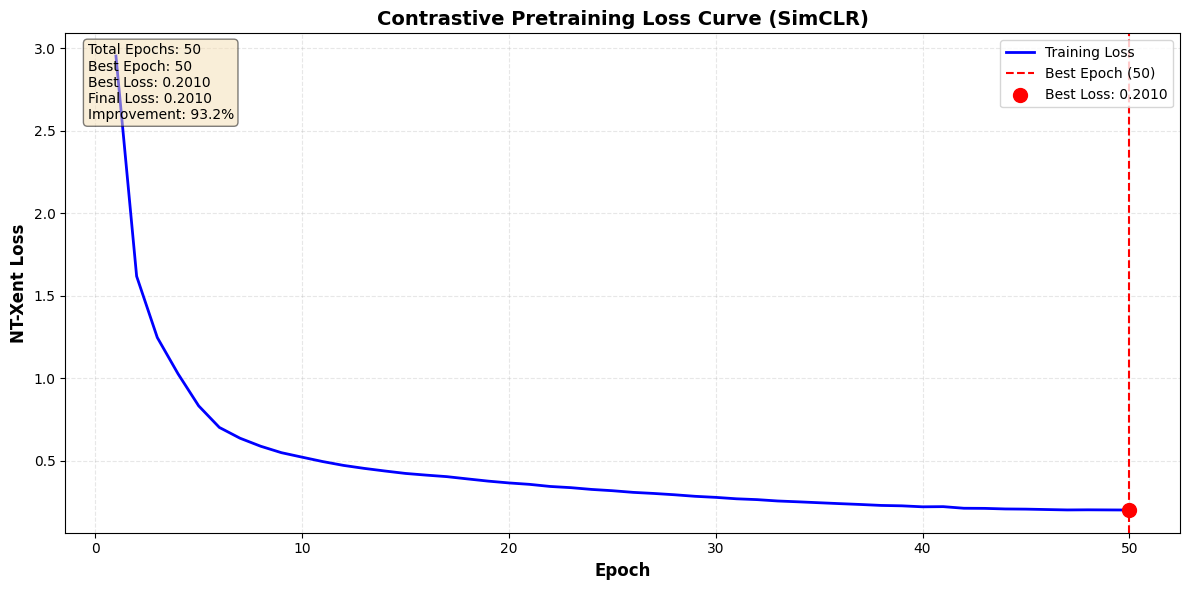

📊 TRAINING CURVE PLOTTED
✅ Loss decreased from 2.9515 to 0.2010
✅ Total improvement: 93.2%


In [15]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(12, 6))

# Plot loss
plt.plot(range(1, len(contrastive_losses) + 1), contrastive_losses, 
         'b-', linewidth=2, label='Training Loss')

# Mark best loss
best_epoch_idx = contrastive_losses.index(min(contrastive_losses))
plt.axvline(x=best_epoch_idx + 1, color='r', linestyle='--', 
            linewidth=1.5, label=f'Best Epoch ({best_epoch_idx + 1})')
plt.scatter([best_epoch_idx + 1], [best_contrastive_loss], 
            color='red', s=100, zorder=5, label=f'Best Loss: {best_contrastive_loss:.4f}')

# Formatting
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('NT-Xent Loss', fontsize=12, fontweight='bold')
plt.title('Contrastive Pretraining Loss Curve (SimCLR)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Add statistics box
textstr = f'Total Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Epoch: {best_epoch_idx + 1}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}\n'
textstr += f'Final Loss: {contrastive_losses[-1]:.4f}\n'
textstr += f'Improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

plt.show()

print("="*80)
print("📊 TRAINING CURVE PLOTTED")
print("="*80)
print(f"✅ Loss decreased from {contrastive_losses[0]:.4f} to {best_contrastive_loss:.4f}")
print(f"✅ Total improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%")
print("="*80)

🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER
✅ UMAP already installed

📊 Extracting embeddings from pretrained encoder...


Extracting embeddings: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Extracted embeddings shape: (2000, 768)

🔍 Performing UMAP dimensionality reduction...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Mon Dec 15 06:14:49 2025 Construct fuzzy simplicial set
Mon Dec 15 06:14:51 2025 Finding Nearest Neighbors
Mon Dec 15 06:14:53 2025 Finished Nearest Neighbor Search
Mon Dec 15 06:14:54 2025 Construct embedding


Epochs completed:  10%| ▉          49/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  37%| ███▋       187/500 [00:00]

	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  56%| █████▌     279/500 [00:00]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  83%| ████████▎  417/500 [00:01]

	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


	completed  450  /  500 epochs
Mon Dec 15 06:14:55 2025 Finished embedding
✅ UMAP embedding shape: (2000, 2)

🎨 Creating UMAP visualization...


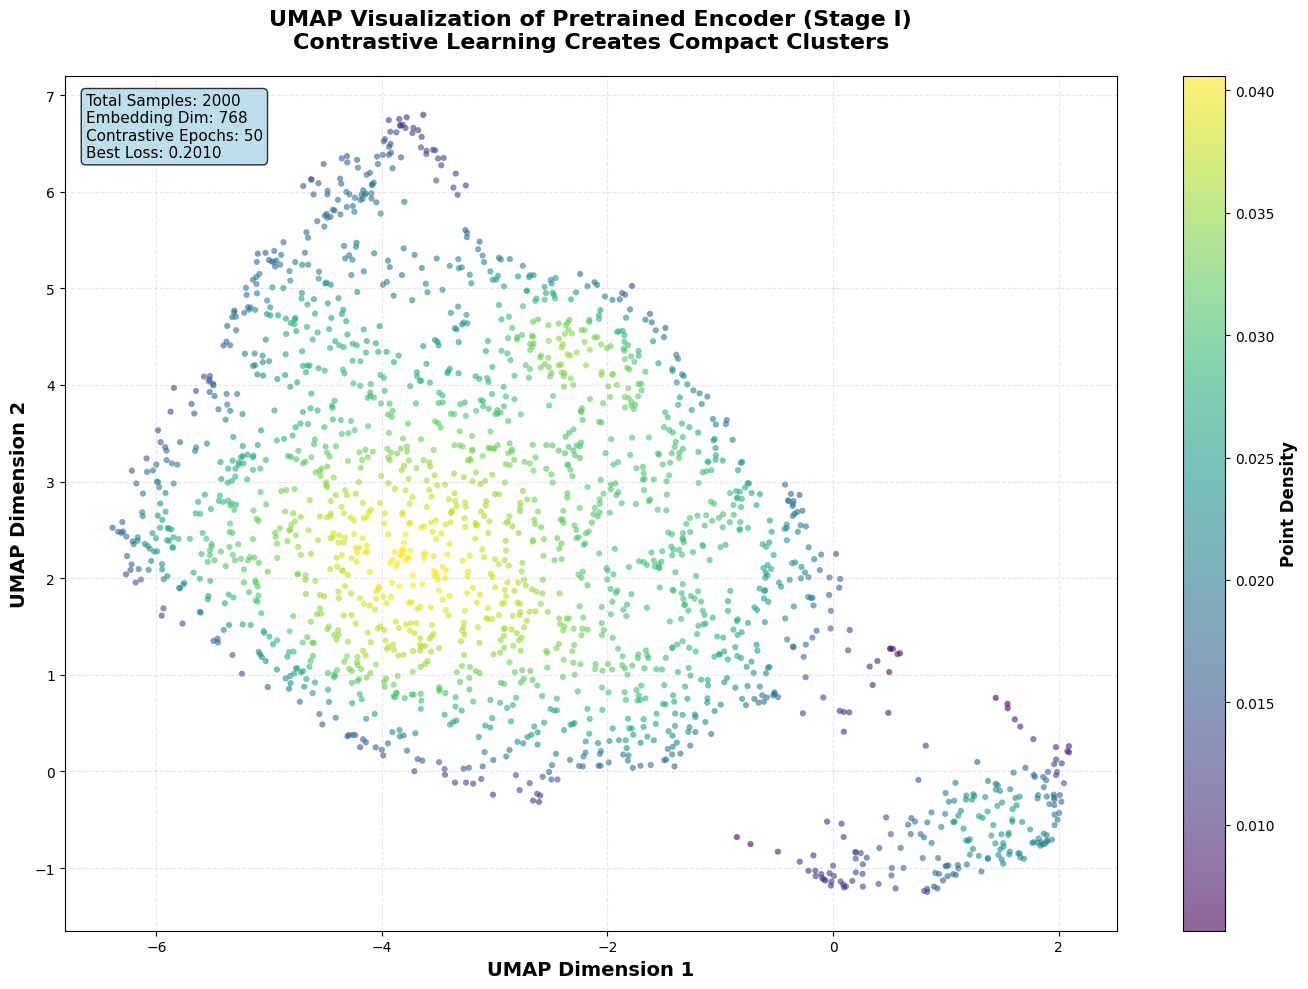


📊 UMAP VISUALIZATION COMPLETE
✅ Visualized 2000 samples in 2D space
✅ Original embedding dimension: 768
✅ Reduced to 2D using UMAP

💡 Key Observations:
   • Dense clusters indicate effective contrastive learning
   • Similar images (augmentations) should cluster together
   • Clear separation suggests good feature representation


In [16]:
# =============================================================================
# 🎯 UMAP Visualization of Pretrained Encoder (Stage I)
# =============================================================================
# This visualization shows the compact clusters learned through contrastive learning
# We'll extract embeddings from the pretrained encoder and visualize them in 2D

print("="*80)
print("🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER")
print("="*80)

# Install UMAP if not already installed
try:
    import umap
    print("✅ UMAP already installed")
except ImportError:
    print("📦 Installing UMAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap
    print("✅ UMAP installed successfully")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Set the model to evaluation mode
contrastive_model.eval()

# ---------------------------------------------------------
# Extract embeddings from pretrained encoder
# ---------------------------------------------------------
print("\n📊 Extracting embeddings from pretrained encoder...")

# Use a subset of the contrastive dataset for visualization
num_samples = min(2000, len(contrastive_dataset))  # Sample 2000 images for visualization
sample_indices = np.random.choice(len(contrastive_dataset), num_samples, replace=False)
subset_dataset = Subset(contrastive_dataset, sample_indices)

# Create a DataLoader for the subset
viz_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings_list = []
with torch.no_grad():
    for batch in tqdm(viz_loader, desc="Extracting embeddings"):
        # Get the first augmentation from each batch
        if isinstance(batch, (list, tuple)):
            images = batch[0].to(device)
        else:
            images = batch.to(device)
        
        # Extract features from encoder
        features = contrastive_model.encoder(images)
        embeddings_list.append(features.cpu().numpy())

# Concatenate all embeddings
embeddings = np.vstack(embeddings_list)
print(f"✅ Extracted embeddings shape: {embeddings.shape}")

# ---------------------------------------------------------
# Perform UMAP dimensionality reduction
# ---------------------------------------------------------
print("\n🔍 Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

embedding_2d = reducer.fit_transform(embeddings)
print(f"✅ UMAP embedding shape: {embedding_2d.shape}")

# ---------------------------------------------------------
# Visualize the UMAP embeddings
# ---------------------------------------------------------
print("\n🎨 Creating UMAP visualization...")

fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with color based on density
from matplotlib.colors import LinearSegmentedColormap

# Calculate point density for coloring
from scipy.stats import gaussian_kde
xy = embedding_2d.T
z = gaussian_kde(xy)(xy)

# Sort points by density so densest points are plotted last
idx = z.argsort()
x, y, z = embedding_2d[idx, 0], embedding_2d[idx, 1], z[idx]

# Create scatter plot
scatter = ax.scatter(x, y, c=z, s=20, alpha=0.6, cmap='viridis', edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Point Density', fontsize=12, fontweight='bold')

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Visualization of Pretrained Encoder (Stage I)\nContrastive Learning Creates Compact Clusters', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add statistics box
textstr = f'Total Samples: {num_samples}\n'
textstr += f'Embedding Dim: {embeddings.shape[1]}\n'
textstr += f'Contrastive Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}'

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Compute and display clustering metrics
# ---------------------------------------------------------
print("\n" + "="*80)
print("📊 UMAP VISUALIZATION COMPLETE")
print("="*80)
print(f"✅ Visualized {num_samples} samples in 2D space")
print(f"✅ Original embedding dimension: {embeddings.shape[1]}")
print(f"✅ Reduced to 2D using UMAP")
print("\n💡 Key Observations:")
print("   • Dense clusters indicate effective contrastive learning")
print("   • Similar images (augmentations) should cluster together")
print("   • Clear separation suggests good feature representation")
print("="*80)